# Operationalizing InSAR and Pixel Offset Time Series Methodologies for Landslide Monitoring

**Author: Forrest Williams**

**Date Created: 12/05/2021**

**Last Modified: 12/10/2021**

## Instructions

This notebook contains the Python code used to generate figures for the my 2021 AGU presentation on detecting landslide movement using timeseries InSAR and pixel offset tracking. The data used to create the presentation can be found [here](https://zenodo.org/record/5768622#.YbN8C73MKUk). To ensure compatability with this notebook, unzip the data directory into the folder containing this notebook, and rename it to `data`. A Docker image that can run this notebook can be found [here](https://hub.docker.com/repository/docker/forrestwilliams/gis). Alternatively, the `gis.yml` file in this directory can be used to create an Anaconda environment that can run the notebook. To ensure proper completion of the notebook, run the cells in order.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
from rasterio.enums import Resampling
from shapely.geometry import box
from rasterio.plot import plotting_extent
import pandas as pd
import numpy as np
import contextily as ctx #basemaps in EPSG:4326
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Patch, Polygon, Circle, Rectangle
from pathlib import Path

In [2]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def format_axis(axis,xlim,ylim,step=1,places=0,show_axis=True):
        
    axis.set(xlim=xlim,ylim=ylim)
    
    if show_axis:
        xticks = np.arange(round_to(xlim[0],step)+step, xlim[1],step)
        yticks = np.arange(round_to(ylim[0],step)+step, ylim[1],step)
        
        axis.set(xticks=xticks,yticks=yticks)

        if xlim[0] > 0:
            xdir = 'W'
        else:
            xdir = 'E'

        if ylim[0] > 0:
            ydir = 'N'
        else:
            ydir = 'S'

        xlabels = [f'{round(abs(x),places)}$\degree${xdir}' for x in xticks]
        ylabels = [f'{round(abs(x),places)}$\degree${ydir}' for x in yticks]

        axis.set_xticklabels(xlabels)
        axis.set_yticklabels(ylabels)
    
    else:
        axis.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    
    return axis

def add_north_arrow(axis,x=0.06, y=0.96, arrow_length=0.1, color='black'):
    axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), color=color,
            arrowprops=dict(color=color, width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=axis.transAxes)
    return axis

def add_scale_bar(axis,width=100,height=15,label='100 m',loc='lower right',color='black'):
    scalebar = AnchoredSizeBar(axis.transData, width, label, loc,
                           pad=0.1,
                           size_vertical=height,
                           color=color,
                           frameon=False,
                           label_top=True)

    axis.add_artist(scalebar)
    return axis

def read_raster(path,bands=1,rgb=False,resample_factor=None):
    with rio.open(path) as dst:
        crs = dst.crs
        extent = plotting_extent(dst)
        
        if resample_factor:
            out_shape=(dst.count,int(dst.height * resample_factor),int(dst.width * resample_factor))
            data = dst.read(out_shape=out_shape,resampling=Resampling.bilinear)
        else:
            data = dst.read(bands)

    if rgb:
        data = np.moveaxis(data,0,-1)

    return (data, crs, extent)

## Peg Plot

In [3]:
peg_rate = pd.read_csv('data/peg_comparison.csv')

In [4]:
rangitikei, crs, rangitikei_extent = read_raster('data/rangitikei_horizons.tif',bands=[1,2,3],rgb=True)

In [5]:
po_ns, _, po_extent = read_raster('data/po_velocity_ns.tif',bands=1)
po_ew, _, _ = read_raster('data/po_velocity_ew.tif',bands=1)

In [6]:
insar_ew, crs, insar_extent = read_raster('data/veloctiy_we_2019.tif',resample_factor=1)
insar_ew = insar_ew[0] * -1

In [7]:
insar_up, crs, insar_extent = read_raster('data/veloctiy_down_2019.tif',resample_factor=1)
insar_up = insar_up[0]

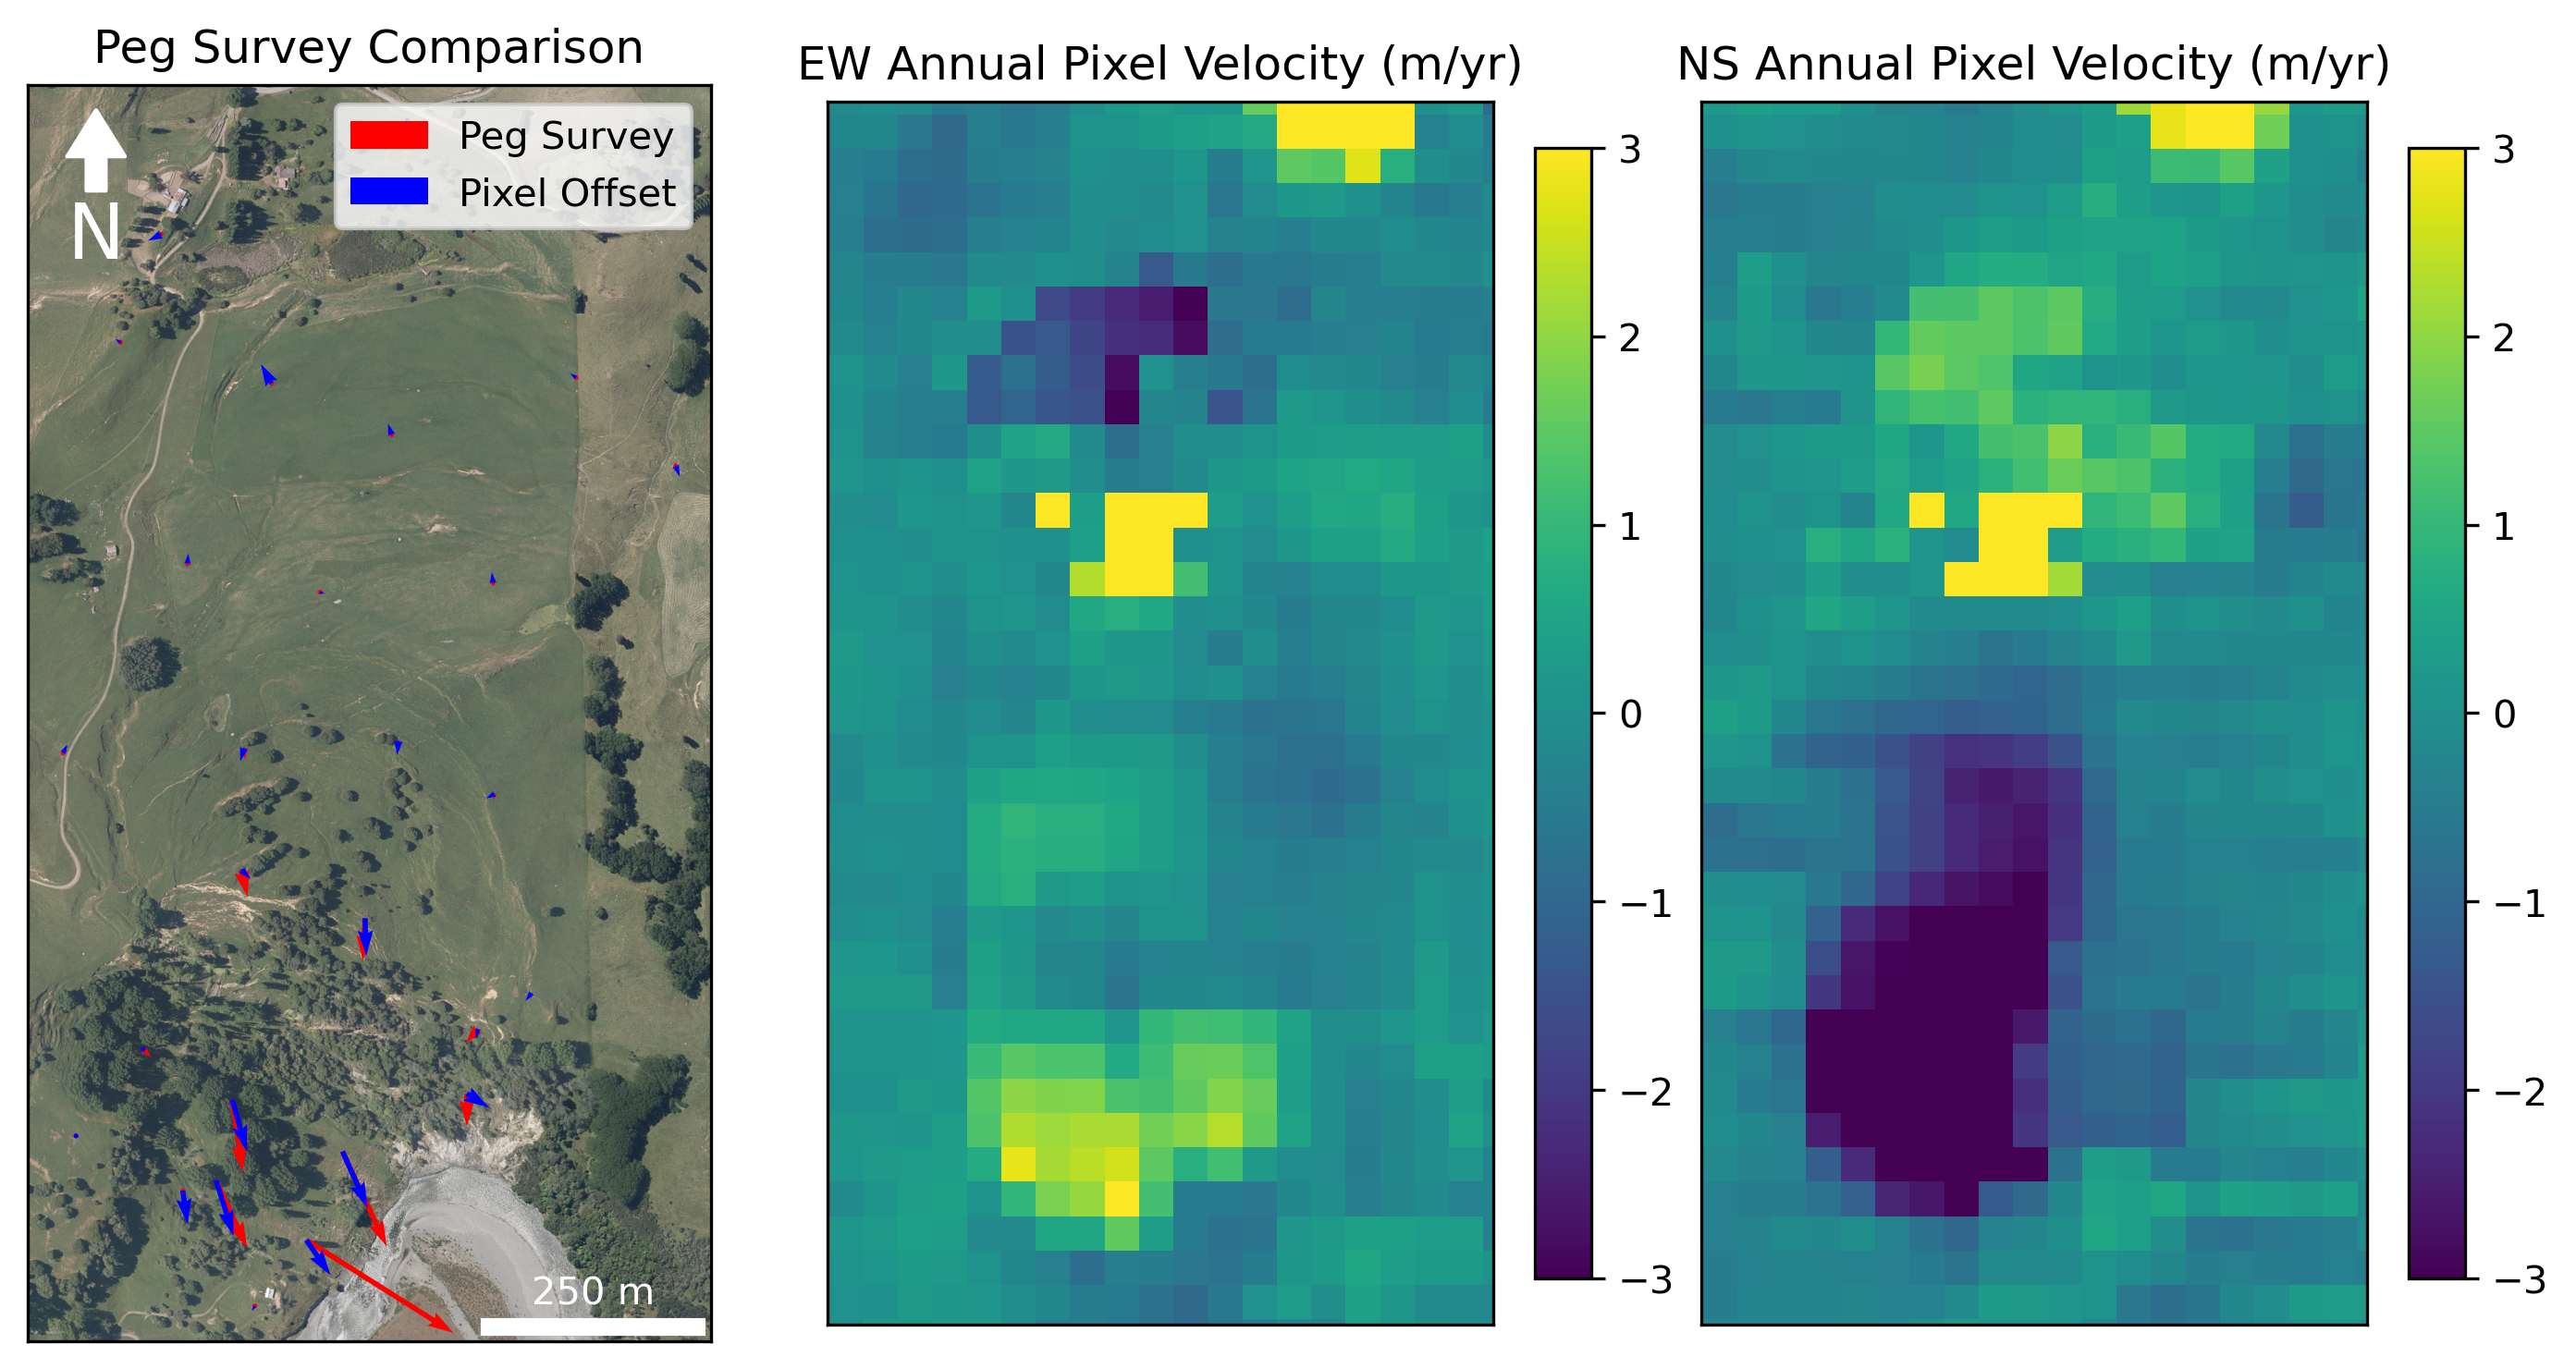

In [8]:
# Setup
b = 20
w, e, s, n = [peg_rate.east.min()-b,peg_rate.east.max()+b,peg_rate.north.min()-b,peg_rate.north.max()+b]
options = dict(angles='xy',scale_units='xy',scale=0.066,width=0.0075)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,6),dpi=300)

# Pegs
ax1.quiver(peg_rate.east, peg_rate.north, peg_rate.e_rate, peg_rate.n_rate,color='red',label='Peg Survey',**options)
ax1.quiver(peg_rate.east, peg_rate.north, peg_rate.pt_e_rate, peg_rate.pt_n_rate,color='blue',label='Pixel Offset',**options)
ax1.imshow(rangitikei,extent=rangitikei_extent,interpolation=None)

ax1.legend(loc='upper right', frameon=True)

ax1 = format_axis(ax1,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Peg Survey Comparison')

# EW
ew_plot = ax2.imshow(po_ew,extent=po_extent,interpolation=None,vmin=-3,vmax=3)
ax2 = format_axis(ax2,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax2.set_title('EW Annual Pixel Velocity (m/yr)')

# NS
ns_plot = ax3.imshow(po_ns,extent=po_extent,interpolation=None,vmin=-3,vmax=3)
ax3 = format_axis(ax3,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax3.set_title('NS Annual Pixel Velocity (m/yr)')

fig.colorbar(ew_plot, ax=ax2, shrink=0.9)
fig.colorbar(ns_plot, ax=ax3, shrink=0.9)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('pegs.png',dpi=300,bbox_inches='tight')

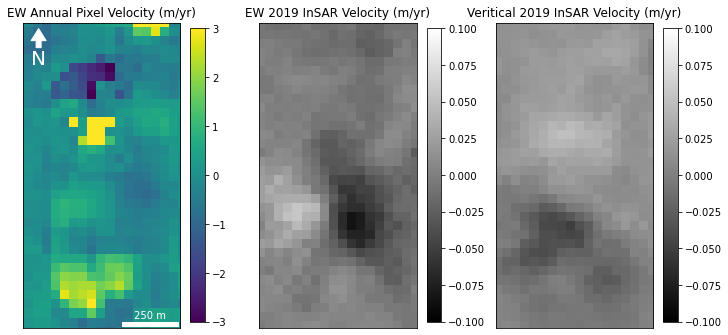

In [10]:
# Setup
b = 0
w, e, s, n = [peg_rate.east.min()-b,peg_rate.east.max()+b,peg_rate.north.min()-b,peg_rate.north.max()+b]

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,6))

# Pixel EW
pixel_plot = ax1.imshow(po_ew,extent=po_extent,interpolation=None,vmin=-3,vmax=3)
ax1.set_title('EW Annual Pixel Velocity (m/yr)')
ax1 = format_axis(ax1,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')

# InSAR EW
insar_ew_plot = ax2.imshow(insar_ew,extent=insar_extent,interpolation=None,vmin=-0.1,vmax=0.1,cmap='gray')
ax2 = format_axis(ax2,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax2.set_title('EW 2019 InSAR Velocity (m/yr)')

# InSAR Up
insar_up_plot = ax3.imshow(insar_up,extent=insar_extent,interpolation=None,vmin=-0.1,vmax=0.1,cmap='gray')
ax3 = format_axis(ax3,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax3.set_title('Veritical 2019 InSAR Velocity (m/yr)')

fig.colorbar(pixel_plot, ax=ax1, shrink=0.9)
fig.colorbar(insar_ew_plot, ax=ax2, shrink=0.9)
fig.colorbar(insar_up_plot, ax=ax3, shrink=0.9)

plt.subplots_adjust(wspace=0.2, hspace=0)
plt.savefig('po_insar_comparison.png',dpi=300,bbox_inches='tight')

## Imagery, InSAR and Pixel Offset Comparison

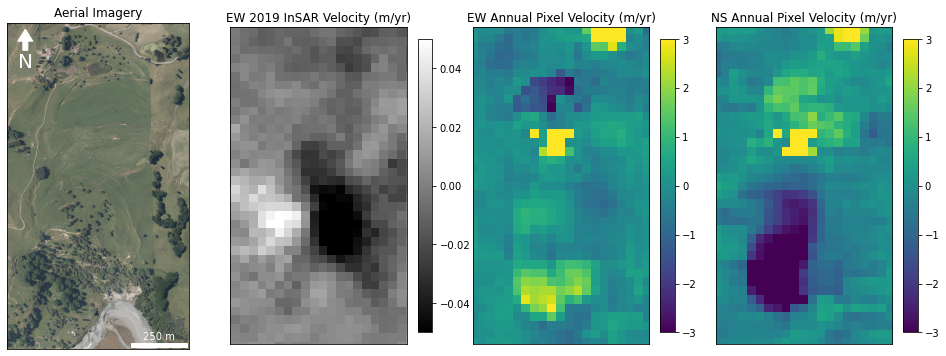

In [8]:
# Setup
b = 30
w, e, s, n = [peg_rate.east.min()-b,peg_rate.east.max()+b,peg_rate.north.min()-b,peg_rate.north.max()+b]

f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(17,6))

# Imagery
ax1.imshow(rangitikei,extent=rangitikei_extent,interpolation=None)

ax1 = format_axis(ax1,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Aerial Imagery')

# InSAR EW
insar_plot = ax2.imshow(insar_ew,extent=insar_extent,interpolation=None,vmin=-0.05,vmax=0.05,cmap='gray')
ax2 = format_axis(ax2,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax2.set_title('EW 2019 InSAR Velocity (m/yr)')

# Pixel EW
pixel_ew_plot = ax3.imshow(po_ew,extent=po_extent,interpolation=None,vmin=-3,vmax=3)
ax3.set_title('EW Annual Pixel Velocity (m/yr)')
ax3 = format_axis(ax3,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

# Pixel NS
pixel_ns_plot = ax4.imshow(po_ns,extent=po_extent,interpolation=None,vmin=-3,vmax=3)
ax4.set_title('NS Annual Pixel Velocity (m/yr)')
ax4 = format_axis(ax4,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

# ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
# ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')

f.colorbar(insar_plot, ax=ax2, shrink=0.9)
f.colorbar(pixel_ew_plot, ax=ax3, shrink=0.9)
f.colorbar(pixel_ns_plot, ax=ax4, shrink=0.9)

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig('imagery_po_insar_comparison.png',dpi=300,bbox_inches='tight')

## Study Area

In [2]:
landslides = gpd.read_file('data/large_landslidesV2.shp').to_crs(32760)

In [5]:
centroid = gpd.GeoSeries(box(*landslides.total_bounds).centroid)

In [6]:
nz_geo = gpd.read_file('data/nz-coastlines-and-islands-polygons-topo-150k.shp').simplify(0.001).to_crs(32760)
nz = gpd.GeoDataFrame({'area':nz_geo.geometry.area}, geometry=nz_geo.geometry)
nz = nz.sort_values('area',ascending=False).reset_index(drop=True).iloc[0:2]

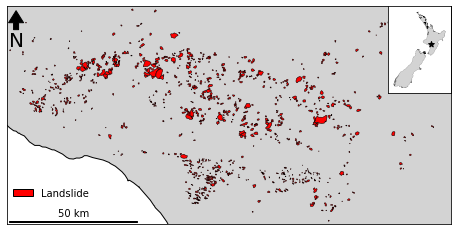

In [20]:
b = 1e3
w, s, e, n = landslides.total_bounds

f, ax = plt.subplots(1,1,figsize=(12, 4))

ax = nz.plot(ax=ax,edgecolor='black',facecolor='lightgrey')
ax = landslides.plot(ax=ax,edgecolor='black',facecolor='red',linewidth=0.5,legend=True,label='Landslides')
ax.set_aspect('equal')
format_axis(ax,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

ax = add_north_arrow(ax,x=0.02, y=0.98, arrow_length=0.14,color='black')
ax = add_scale_bar(ax,width=50000,height=500,label='50 km',color='black',loc='lower left')
legend_elements = [Patch(facecolor='red',edgecolor='black',label='Landslide')]
ax.legend(handles=legend_elements, loc=(0.005,0.1), frameon=False)

w, s, e, n = nz.total_bounds
b = 1e5
ax_inset = ax.inset_axes([0.729,0.6,0.4,0.4])
ax_inset = nz.plot(ax=ax_inset,edgecolor='black',facecolor='lightgrey',linewidth=0.1)
ax_inset = centroid.plot(ax=ax_inset,color='black',marker='*')
ax_inset.set_aspect('equal')
format_axis(ax_inset,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

plt.savefig('study_area.png',dpi=300,bbox_inches='tight')

## InSAR Study Area

### Full

In [8]:
insar_ew, crs, insar_extent = read_raster('data/veloctiy_we_2019.tif',resample_factor=0.25)
insar_ew = insar_ew[0] * -1 #convention was accidentally flipped

In [9]:
landslides = gpd.read_file('data/large_landslidesV2.shp').to_crs(32760)
landslides['Name'] = landslides['Name'].astype(int)

In [10]:
active_ids = [386, 454, 539, 402, 843, 846, 729, 757, 230, 155]
subset_ids = active_ids[2:-3]
active = landslides.loc[landslides.Name.isin(active_ids)].copy().buffer(500)
subset = landslides.loc[landslides.Name.isin(subset_ids)].copy()

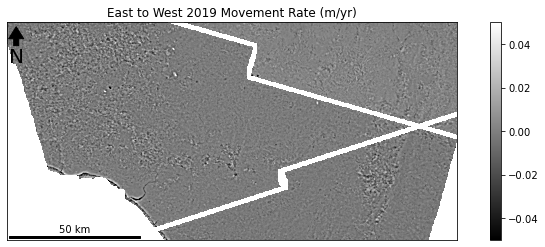

In [24]:
b = 0
w, s, e, n = landslides.total_bounds
subset_area = gpd.GeoSeries(box(*subset.total_bounds)).buffer(1000)

f, ax = plt.subplots(1,1,figsize=(12, 4))

insar_plot = ax.imshow(insar_ew,cmap='gray',interpolation=None,vmin=-0.05,vmax=0.05,extent=insar_extent)
# ax = active.plot(ax=ax,edgecolor='red',facecolor=(0,0,0,0),linewidth=1)
# ax = subset_area.plot(ax=ax,edgecolor='blue',facecolor=(0,0,0,0),linewidth=1)

f.colorbar(insar_plot, ax=ax)

ax.set_title('East to West 2019 Movement Rate (m/yr)')
ax = add_north_arrow(ax,x=0.02, y=0.98, arrow_length=0.14,color='black')
ax = add_scale_bar(ax,width=50000,height=500,label='50 km',color='black',loc='lower left')
ax.set_aspect('equal')
format_axis(ax,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

plt.savefig('insar_vanilla.png',dpi=300,bbox_inches='tight')

### Zoom in

In [25]:
insar_ew, crs, insar_extent = read_raster('data/veloctiy_we_2019.tif',resample_factor=1)
insar_ew = insar_ew[0] * -1 #convention was accidentally flipped

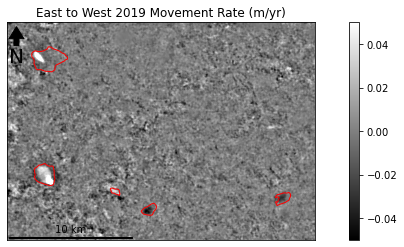

In [26]:
b = 1000
w, s, e, n = subset_area.total_bounds

f, ax = plt.subplots(1,1,figsize=(12, 4))

insar_plot = ax.imshow(insar_ew,cmap='gray',interpolation=None,vmin=-0.05,vmax=0.05,extent=insar_extent)
ax = subset.plot(ax=ax,edgecolor='red',facecolor=(0,0,0,0),linewidth=1)

f.colorbar(insar_plot, ax=ax)

ax.set_title('East to West 2019 Movement Rate (m/yr)')
ax = add_north_arrow(ax,x=0.03, y=0.98, arrow_length=0.14,color='black')
ax = add_scale_bar(ax,width=10000,height=100,label='10 km',color='black',loc='lower left')
ax.set_aspect('equal')
format_axis(ax,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

plt.savefig('insar_zoomin.png',dpi=300,bbox_inches='tight')

## Examples

In [12]:
diffvel, crs, diffvel_extent = read_raster('data/landslides_diffvel_horizons.tif',bands=[1,2,3],rgb=True)

In [13]:
river, crs, river_extent = read_raster('data/landslides_river_horizons.tif',bands=[1,2,3],rgb=True)

In [14]:
insar_ew, crs, insar_extent = read_raster('data/veloctiy_we_2019.tif',resample_factor=1)
insar_ew = insar_ew[0] * -1 #convention was accidentally flipped

In [15]:
landslides = gpd.read_file('data/large_landslidesV2.shp').to_crs(32760)
landslides['Name'] = landslides['Name'].astype(int)
diffvel_landslide = landslides[landslides.Name == 402]
river_landslide = landslides[landslides.Name == 729]

### Example 1

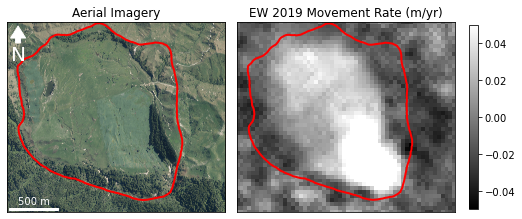

In [16]:
b = 0
w, e, s, n = diffvel_extent
f, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4),gridspec_kw={'width_ratios':[4.45,5.55]})

ax1.imshow(diffvel,extent=diffvel_extent)
ax1 = diffvel_landslide.plot(ax=ax1,edgecolor='red',facecolor=(0,0,0,0),linewidth=2)
ax1.set_aspect('equal')
ax1 = format_axis(ax1,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

ax1 = add_north_arrow(ax1,x=0.05, y=0.98, arrow_length=0.15, color='white')
ax1 = add_scale_bar(ax1,width=500,height=15,label='500 m',color='white',loc='lower left')
ax1.set_title('Aerial Imagery')

insar_plot = ax2.imshow(insar_ew,cmap='gray',interpolation=None,vmin=-0.05,vmax=0.05,extent=insar_extent)
ax2 = diffvel_landslide.plot(ax=ax2,edgecolor='red',facecolor=(0,0,0,0),linewidth=2)
ax2.set_aspect('equal')
ax2 = format_axis(ax2,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax2.set_title('EW 2019 Movement Rate (m/yr)')

f.colorbar(insar_plot, ax=ax2, shrink=0.85)
plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig('diffvel_landslide.png',dpi=300,bbox_inches='tight')

### Example 2

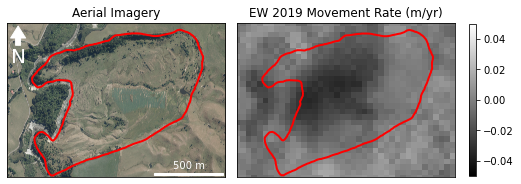

In [17]:
b = 0
w, e, s, n = river_extent
f, (ax1,ax2) = plt.subplots(1,2,figsize=(9,4),gridspec_kw={'width_ratios':[4.45,5.55]})

ax1.imshow(river,extent=river_extent)
ax1 = river_landslide.plot(ax=ax1,edgecolor='red',facecolor=(0,0,0,0),linewidth=2)
ax1.set_aspect('equal')
ax1 = format_axis(ax1,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

ax1 = add_north_arrow(ax1,x=0.05, y=0.98, arrow_length=0.2, color='white')
ax1 = add_scale_bar(ax1,width=500,height=15,label='500 m',color='white',loc='lower right')
ax1.set_title('Aerial Imagery')

insar_plot = ax2.imshow(insar_ew,cmap='gray',interpolation=None,vmin=-0.05,vmax=0.05,extent=insar_extent)
ax2 = river_landslide.plot(ax=ax2,edgecolor='red',facecolor=(0,0,0,0),linewidth=2)
ax2.set_aspect('equal')
ax2 = format_axis(ax2,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)
ax2.set_title('EW 2019 Movement Rate (m/yr)')

fig.colorbar(insar_plot, ax=ax2, shrink=0.7)
plt.subplots_adjust(wspace=0.05, hspace=0)

plt.savefig('river_landslide.png',dpi=300,bbox_inches='tight')

## For Zoomed Map

In [59]:
insar_ew, crs, insar_extent = read_raster('data/veloctiy_we_2019.tif',resample_factor=0.25)
insar_ew = insar_ew[0] * -1 #convention was accidentally flipped

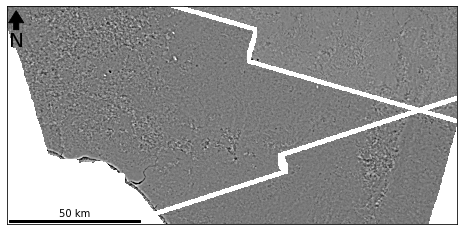

In [61]:
b = 0
w, s, e, n = landslides.total_bounds
subset_area = gpd.GeoSeries(box(*subset.total_bounds)).buffer(1000)

f, ax = plt.subplots(1,1,figsize=(12, 4))

insar_plot = ax.imshow(insar_ew,cmap='gray',interpolation=None,vmin=-0.05,vmax=0.05,extent=insar_extent)

# f.colorbar(insar_plot, ax=ax)

# ax.set_title('East to West 2019 Movement Rate (m/yr)')
ax = add_north_arrow(ax,x=0.02, y=0.98, arrow_length=0.14,color='black')
ax = add_scale_bar(ax,width=50000,height=500,label='50 km',color='black',loc='lower left')
ax.set_aspect('equal')
format_axis(ax,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

plt.savefig('insar_big.png',dpi=300,bbox_inches='tight')